# Notebook 03 — Modelling

# 1. Imports

In [1]:
# Standard library
import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Notebook setup
from utils.notebook_setup import setup_notebook

# Data handling
import numpy as np
import pandas as pd
import statsmodels.api as sm
from utils.data_loading import load_data

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing / feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Modeling
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, Ridge, RidgeCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import joblib
from utils.model_evaluation import plot_residuals, evaluate_regression_metrics_df, plot_residuals_vs_fitted, plot_residuals_grid

In [2]:
print("Current working directory:", Path.cwd())

Current working directory: c:\Users\gabri\Documents\Dokumenty\job-satisfaction-analysis\notebooks


# 2. Settings / Configuration

In [3]:
setup_notebook(seed=42)

# 3. Loading data

In [4]:
df_clean, meta = load_data("../data/processed/clean_data.csv")

In [5]:
df_clean.head()

,id,wiek,m1,woj,m2,g8,wykszt_7k,j1_02,j1_03,j1_04,...,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01,satisfaction,generation
0,6591,19,2002,10,0,3,3,4,5,5,...,2,7.0,3000.0,5,2600,7500,14000,4,4.0,Z
1,6592,37,1984,10,1,2,7,2,3,4,...,4,3.0,1100.0,4,2500,3000,4500,2,2.0,M
2,6594,24,1997,14,1,2,6,5,5,5,...,5,9.0,4800.0,5,6000,7500,10000,5,4.0,Z
3,6598,49,1972,24,1,2,5,3,5,5,...,5,10.0,5000.0,4,3500,5500,6500,4,4.0,X
4,6601,46,1975,22,1,2,7,3,5,5,...,2,10.0,5000.0,4,-7,-7,-7,2,2.0,X


# 4. Defining predictors and target

In [6]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

salary_predictor = ["m9d"]

In [7]:
df_clean.columns.tolist()

['id',
 'wiek',
 'm1',
 'woj',
 'm2',
 'g8',
 'wykszt_7k',
 'j1_02',
 'j1_03',
 'j1_04',
 'j1_05',
 'j1_06',
 'j1_07',
 'j1_08',
 'j1_09',
 'j1_10',
 'j3_01',
 'j3_02',
 'j3_03',
 'j3_04',
 'j3_05',
 'j3_06',
 'j3_07',
 'j3_08',
 'j3_09',
 'j3_10',
 'j3_11',
 'j3_12',
 'j3_13',
 'm9_13k',
 'm9d',
 'm13',
 'o1_1',
 'o1_2',
 'o1_3',
 'j1_01',
 'satisfaction',
 'generation']

In [8]:
y = df_clean['satisfaction']

In [12]:
print(f"Type of salary_predictor: {type(salary_predictor)}")

Type of salary_predictor: <class 'list'>


In [14]:
predictors_to_check = likert_predictors.copy()
if salary_predictor:
    predictors_to_check = predictors_to_check + salary_predictor
    
for predictor in predictors_to_check:
    if predictor in df_clean.columns:
        unique_vals = sorted(df_clean[predictor].dropna().unique())
        print(f"{predictor}: {len(unique_vals)} values → {unique_vals}")

j1_01: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_02: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_03: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_04: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_05: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_06: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_07: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_08: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_09: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_10: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j3_01: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j3_02: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.in

In [15]:
X_likert = df_clean[likert_predictors]
X_all = df_clean[likert_predictors + salary_predictor]

In [16]:
train_idx, test_idx = train_test_split(df_clean.index, test_size=0.2, random_state=42)

In [17]:
# Likert predictors
X_train_likert = df_clean.loc[train_idx, likert_predictors]
X_test_likert = df_clean.loc[test_idx, likert_predictors]

In [18]:
# Likert + salary
X_train_all = df_clean.loc[train_idx, likert_predictors + salary_predictor]
X_test_all = df_clean.loc[test_idx, likert_predictors + salary_predictor]

In [19]:
# Target
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

# 5. Scaling and data preprocessing

In [20]:
salary_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), 
    ('scale', StandardScaler())
])

In [21]:
preprocessor_likert = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
    ])

In [22]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
        ('salary_scaler', salary_pipeline, salary_predictor)
    ])

In [23]:
X_train_l_scaled = preprocessor_likert.fit_transform(X_train_likert)
X_train_a_scaled = preprocessor_all.fit_transform(X_train_all)
X_test_l_scaled = preprocessor_likert.transform(X_test_likert)
X_test_a_scaled = preprocessor_all.transform(X_test_all)

In [24]:
print("Mean of each scaled column:", np.mean(X_train_l_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_l_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
print("Mean of each scaled column:", np.mean(X_train_a_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_a_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


# 6. Model building and evaluation

In [26]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LassoCV": LassoCV(),
    "Ridge": Ridge(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "ElasticNetCV": ElasticNetCV()
}

datasets = {
    "Likert Only": (X_train_l_scaled, X_test_l_scaled),
    "All Predictors": (X_train_a_scaled, X_test_a_scaled)
}

In [27]:
trained_models = {
    "Likert Only": {},
    "All Predictors": {}
}
evaluation_results = []


--- Dataset: Likert Only ---

Linear Regression


,Metric,Value
0,MSE,0.5620
1,RMSE,0.7497
2,RMSPE [%],33.6782
3,MAE,0.4365
4,MAPE [%],16.6520
5,R²,0.3176
6,Korelacja Pearsona,0.5638


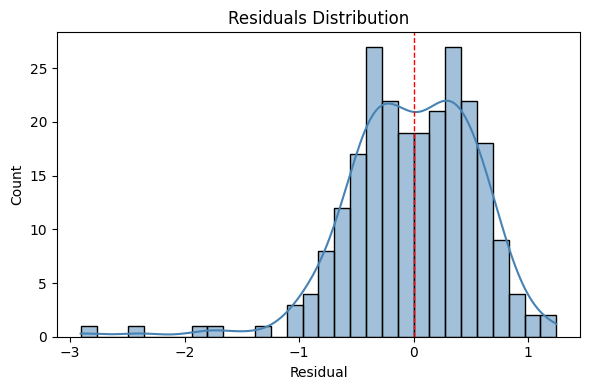


Random Forest


,Metric,Value
0,MSE,0.5882
1,RMSE,0.7670
2,RMSPE [%],35.0124
3,MAE,0.4522
4,MAPE [%],17.2729
5,R²,0.2525
6,Korelacja Pearsona,0.5075


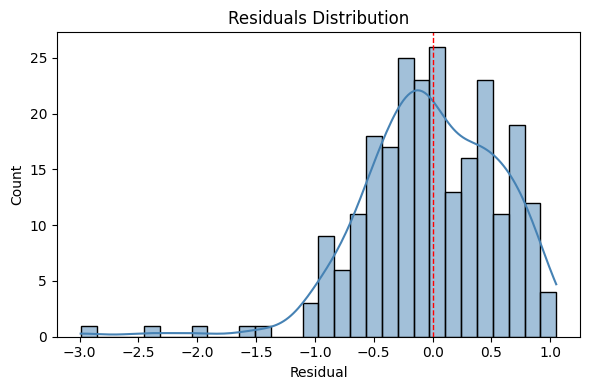


XGBoost


,Metric,Value
0,MSE,0.6194
1,RMSE,0.7870
2,RMSPE [%],36.8568
3,MAE,0.4713
4,MAPE [%],18.1745
5,R²,0.1712
6,Korelacja Pearsona,0.4649


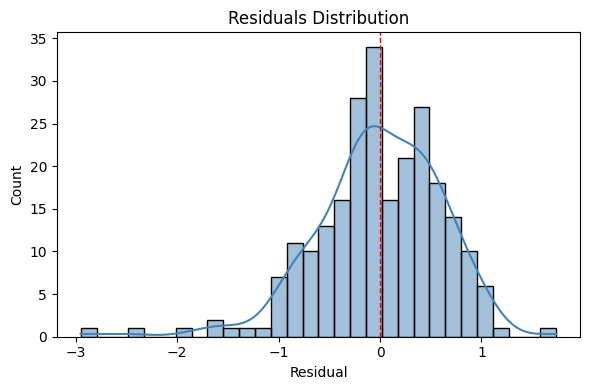


SVR


,Metric,Value
0,MSE,0.6115
1,RMSE,0.7820
2,RMSPE [%],38.6166
3,MAE,0.4462
4,MAPE [%],17.7214
5,R²,0.1923
6,Korelacja Pearsona,0.4464


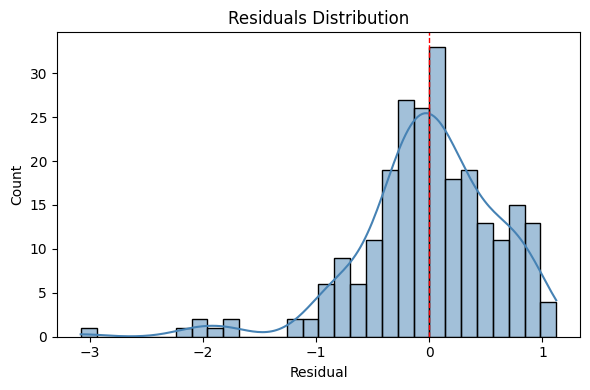


KNN


,Metric,Value
0,MSE,0.6080
1,RMSE,0.7797
2,RMSPE [%],36.8804
3,MAE,0.4357
4,MAPE [%],17.1369
5,R²,0.2015
6,Korelacja Pearsona,0.4569


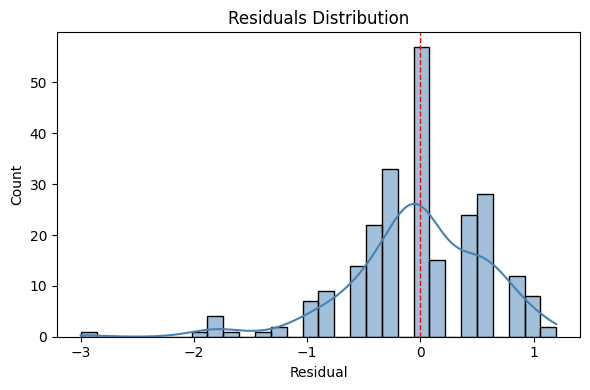


LassoCV


,Metric,Value
0,MSE,0.5634
1,RMSE,0.7506
2,RMSPE [%],33.9443
3,MAE,0.4399
4,MAPE [%],16.8219
5,R²,0.3144
6,Korelacja Pearsona,0.5623


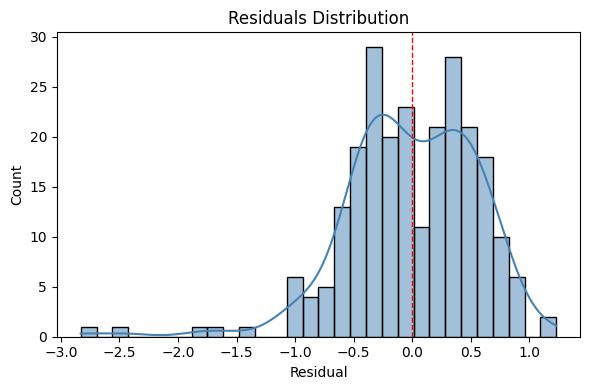


Ridge


,Metric,Value
0,MSE,0.5620
1,RMSE,0.7497
2,RMSPE [%],33.6809
3,MAE,0.4365
4,MAPE [%],16.6524
5,R²,0.3176
6,Korelacja Pearsona,0.5638


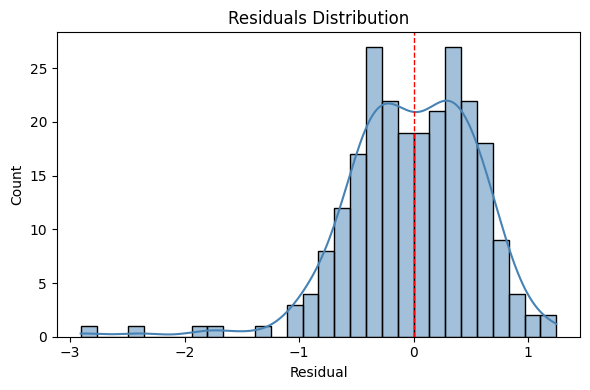


Gradient Boosting


,Metric,Value
0,MSE,0.5795
1,RMSE,0.7613
2,RMSPE [%],34.3829
3,MAE,0.4399
4,MAPE [%],16.8906
5,R²,0.2745
6,Korelacja Pearsona,0.5317


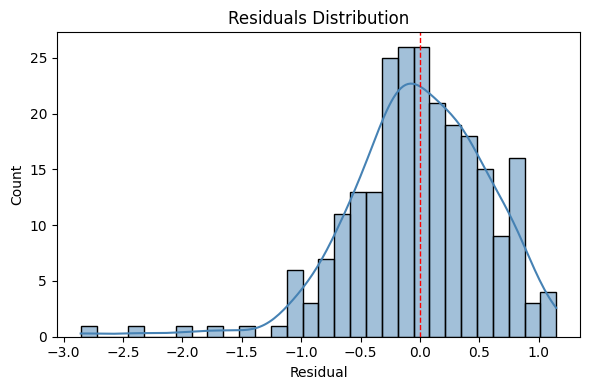


ElasticNetCV


,Metric,Value
0,MSE,0.5635
1,RMSE,0.7506
2,RMSPE [%],33.9759
3,MAE,0.4400
4,MAPE [%],16.8305
5,R²,0.3142
6,Korelacja Pearsona,0.5622


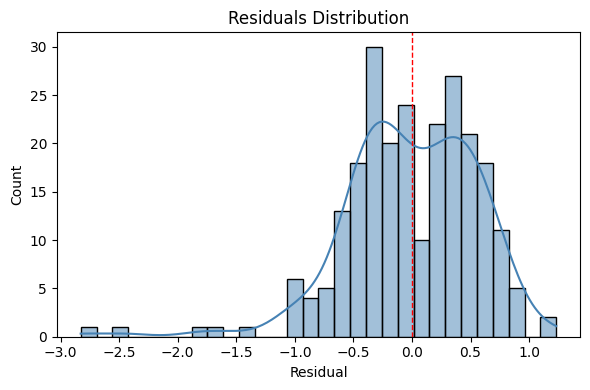


--- Dataset: All Predictors ---

Linear Regression


,Metric,Value
0,MSE,0.5619
1,RMSE,0.7496
2,RMSPE [%],33.7321
3,MAE,0.4362
4,MAPE [%],16.6718
5,R²,0.3179
6,Korelacja Pearsona,0.5641


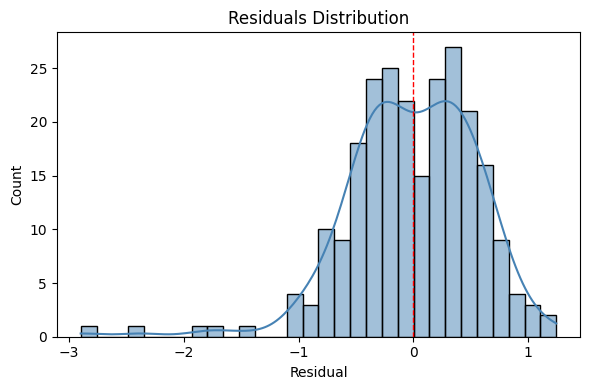


Random Forest


,Metric,Value
0,MSE,0.5724
1,RMSE,0.7566
2,RMSPE [%],34.4769
3,MAE,0.4362
4,MAPE [%],16.7348
5,R²,0.2922
6,Korelacja Pearsona,0.5414


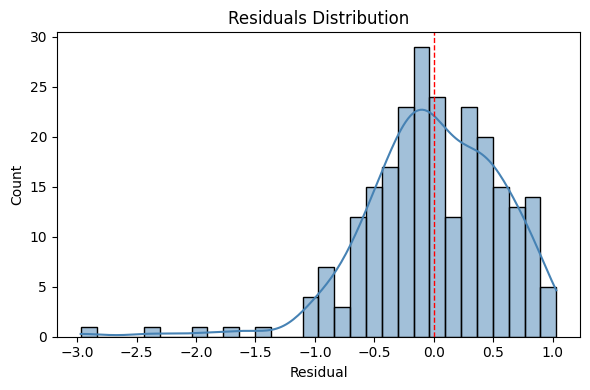


XGBoost


,Metric,Value
0,MSE,0.6229
1,RMSE,0.7893
2,RMSPE [%],39.3703
3,MAE,0.4586
4,MAPE [%],18.0677
5,R²,0.1617
6,Korelacja Pearsona,0.4517


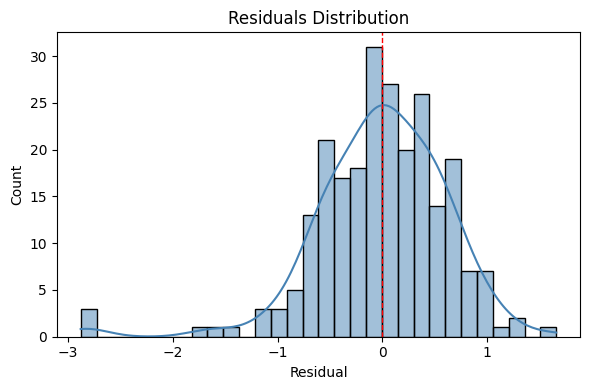


SVR


,Metric,Value
0,MSE,0.6058
1,RMSE,0.7783
2,RMSPE [%],38.3494
3,MAE,0.4439
4,MAPE [%],17.6231
5,R²,0.2072
6,Korelacja Pearsona,0.4605


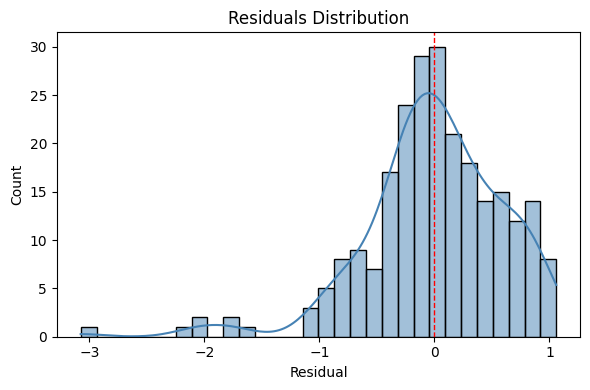


KNN


,Metric,Value
0,MSE,0.6208
1,RMSE,0.7879
2,RMSPE [%],37.6282
3,MAE,0.4498
4,MAPE [%],17.6902
5,R²,0.1674
6,Korelacja Pearsona,0.4266


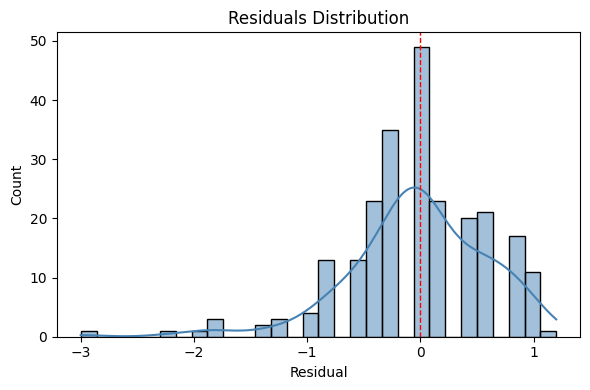


LassoCV


,Metric,Value
0,MSE,0.5632
1,RMSE,0.7504
2,RMSPE [%],33.9515
3,MAE,0.4396
4,MAPE [%],16.8182
5,R²,0.3149
6,Korelacja Pearsona,0.5627


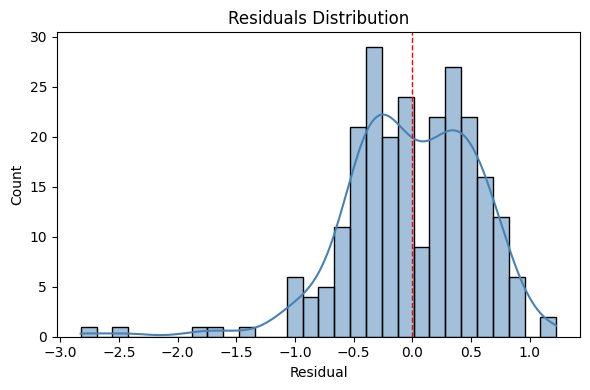


Ridge


,Metric,Value
0,MSE,0.5619
1,RMSE,0.7496
2,RMSPE [%],33.7348
3,MAE,0.4362
4,MAPE [%],16.6724
5,R²,0.3179
6,Korelacja Pearsona,0.5641


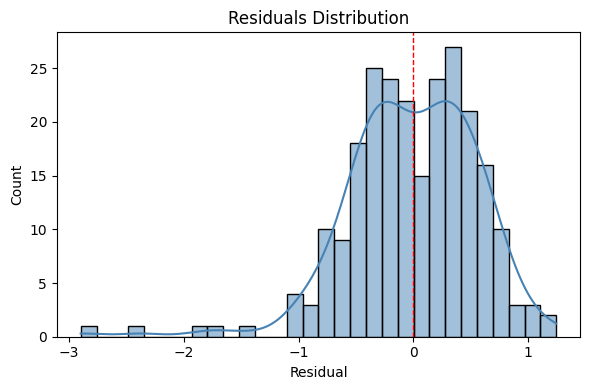


Gradient Boosting


,Metric,Value
0,MSE,0.5621
1,RMSE,0.7497
2,RMSPE [%],34.4825
3,MAE,0.4218
4,MAPE [%],16.3853
5,R²,0.3175
6,Korelacja Pearsona,0.5638


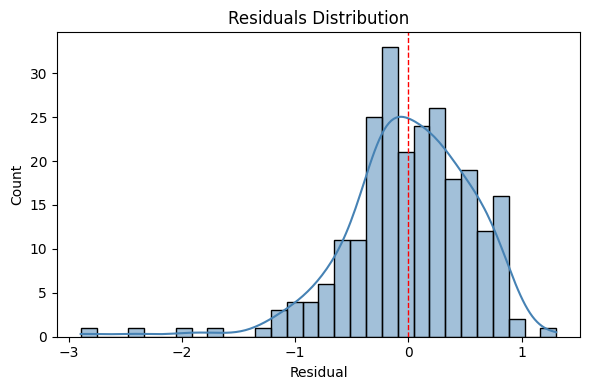


ElasticNetCV


,Metric,Value
0,MSE,0.5633
1,RMSE,0.7505
2,RMSPE [%],33.9838
3,MAE,0.4397
4,MAPE [%],16.8267
5,R²,0.3146
6,Korelacja Pearsona,0.5627


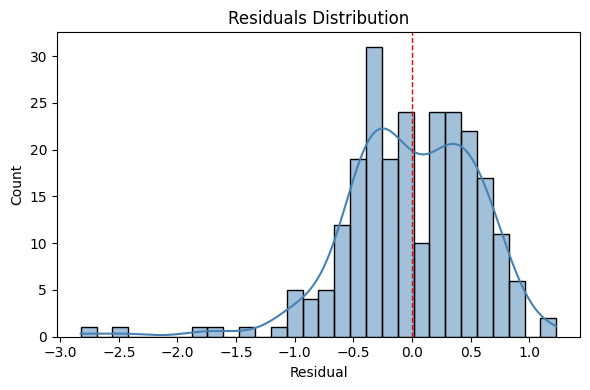

In [28]:
for data_name, (Xtr, Xte) in datasets.items():
    print(f"\n--- Dataset: {data_name} ---")

    for model_name, model in models.items():
        # Training the model
        print(f"\n{model_name}")
        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)

        # Saving the model and its test set
        trained_models[data_name][model_name] = {
            "model": model,
            "X_test": Xte,
            "y_pred": y_pred
        }

        # Evaluating the model
        metrics = evaluate_regression_metrics_df(y_test, y_pred)
        display(metrics)

        plot_residuals(y_test, y_pred)

        metrics["model"] = model_name
        metrics["dataset"] = data_name
        evaluation_results.append(metrics)

# 7. Model Comparison

## 7.1 Residual plots for top models

In [29]:
comparison_results = []

Using trained models from section 6

In [30]:
for dataset_name in trained_models.keys():
    for model_name, entry in trained_models[dataset_name].items():
        y_pred = entry["y_pred"]
        
        y_test_vals = y_test.values

        # Calculate metrics
        diffs = y_test_vals - y_pred
        
        comparison_results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "R2": round(r2_score(y_test_vals, y_pred), 3),
            "RMSE": round(np.sqrt(np.mean(diffs**2)), 3),
            "MAE": round(np.mean(np.abs(diffs)), 3),
            "Pearson r": round(np.corrcoef(y_test_vals, y_pred)[0, 1], 3)
        })

comparison_df = pd.DataFrame(comparison_results).sort_values(by="R2", ascending=False)
display(comparison_df)

,Model,Dataset,R2,RMSE,MAE,Pearson r
0,Linear Regression,Likert Only,0.318,0.562,0.436,0.564
9,Linear Regression,All Predictors,0.318,0.562,0.436,0.564
15,Ridge,All Predictors,0.318,0.562,0.436,0.564
6,Ridge,Likert Only,0.318,0.562,0.436,0.564
16,Gradient Boosting,All Predictors,0.317,0.562,0.422,0.564
14,LassoCV,All Predictors,0.315,0.563,0.440,0.563
17,ElasticNetCV,All Predictors,0.315,0.563,0.440,0.563
5,LassoCV,Likert Only,0.314,0.563,0.440,0.562
8,ElasticNetCV,Likert Only,0.314,0.563,0.440,0.562
10,Random Forest,All Predictors,0.292,0.572,0.436,0.541


Retrieving top models for both categories

In [31]:
top_models_all = comparison_df[comparison_df["Dataset"] == "All Predictors"].head(4)

In [32]:
top_models_likert = comparison_df[comparison_df["Dataset"] == "Likert Only"].head(4)

In [33]:
print(top_models_all)

                Model         Dataset     R2   RMSE    MAE  Pearson r
9   Linear Regression  All Predictors  0.318  0.562  0.436      0.564
15              Ridge  All Predictors  0.318  0.562  0.436      0.564
16  Gradient Boosting  All Predictors  0.317  0.562  0.422      0.564
14            LassoCV  All Predictors  0.315  0.563  0.440      0.563


In [34]:
print(top_models_likert)

               Model      Dataset     R2   RMSE    MAE  Pearson r
0  Linear Regression  Likert Only  0.318  0.562  0.436      0.564
6              Ridge  Likert Only  0.318  0.562  0.436      0.564
5            LassoCV  Likert Only  0.314  0.563  0.440      0.562
8       ElasticNetCV  Likert Only  0.314  0.563  0.440      0.562


In [36]:
all_predictors_models = trained_models["All Predictors"]

In [37]:
likert_models = trained_models["Likert Only"]

##### Key observations

Given the linear models' superior performance, data is mostly linear. The difference between linear regression and regularized models like LassoCV, Ridge is negligible. Complex models are performing significantly worse, meaning non-linearity is most likely noise. Salary feature has a negligible effect. Overall R2 is low, which is quite respectable for social science survey data predicting a 4-point ordinal outcome from other Likert items. Multicollinearity is likely not a significant problem to be addressed.


Residual Plots - All Predictors:


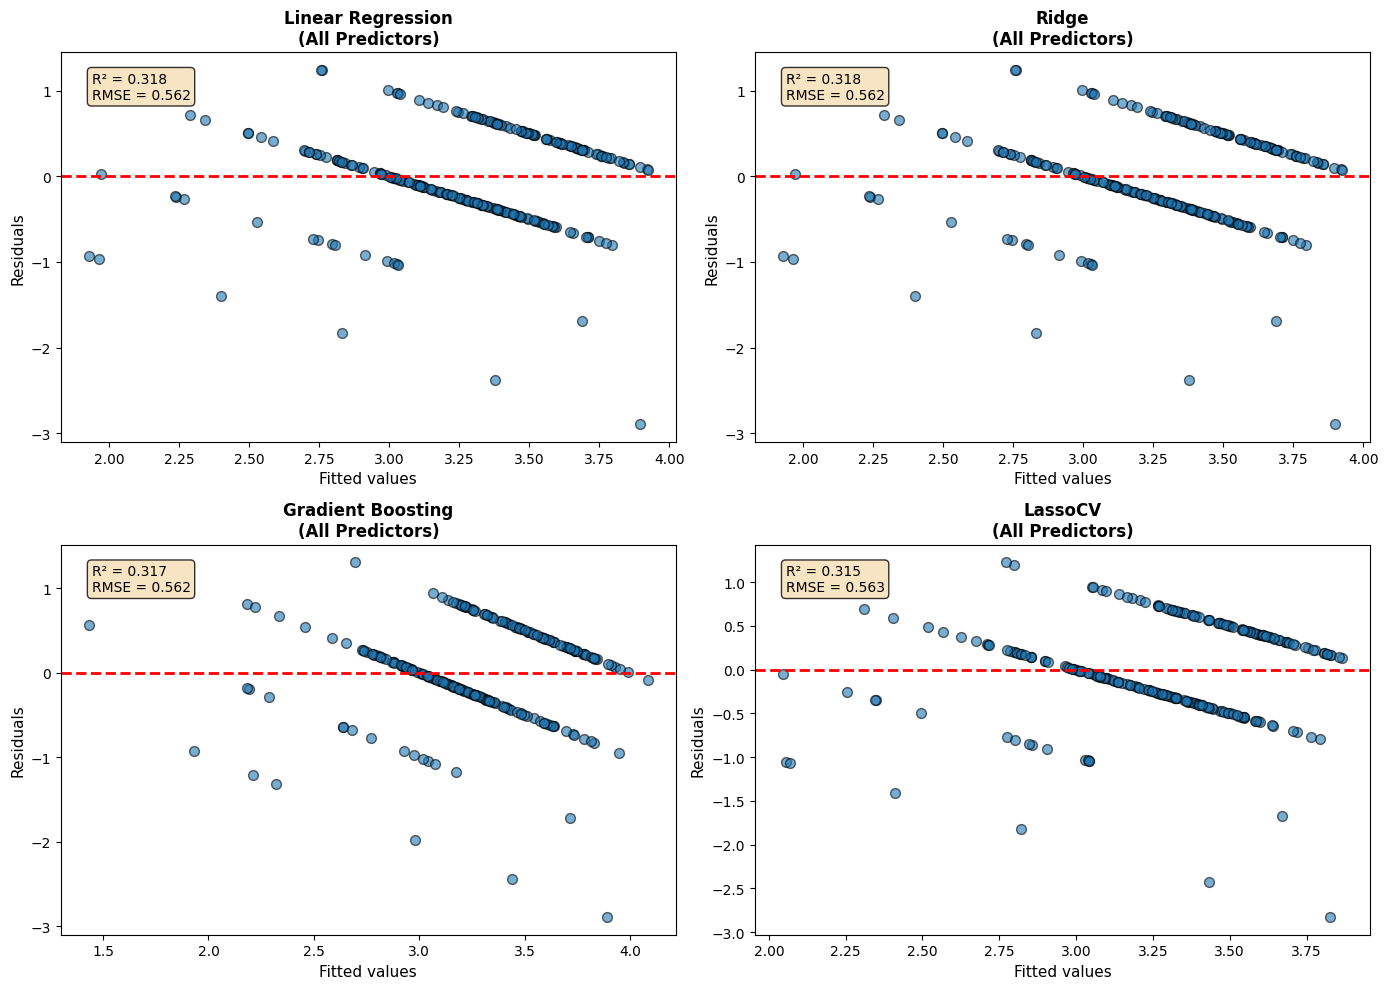

In [40]:
print("\nResidual Plots - All Predictors:")
fig1, axes1 = plot_residuals_grid(trained_models, comparison_df, "All Predictors", y_test)
plt.show()


Residual Plots - Likert Only:


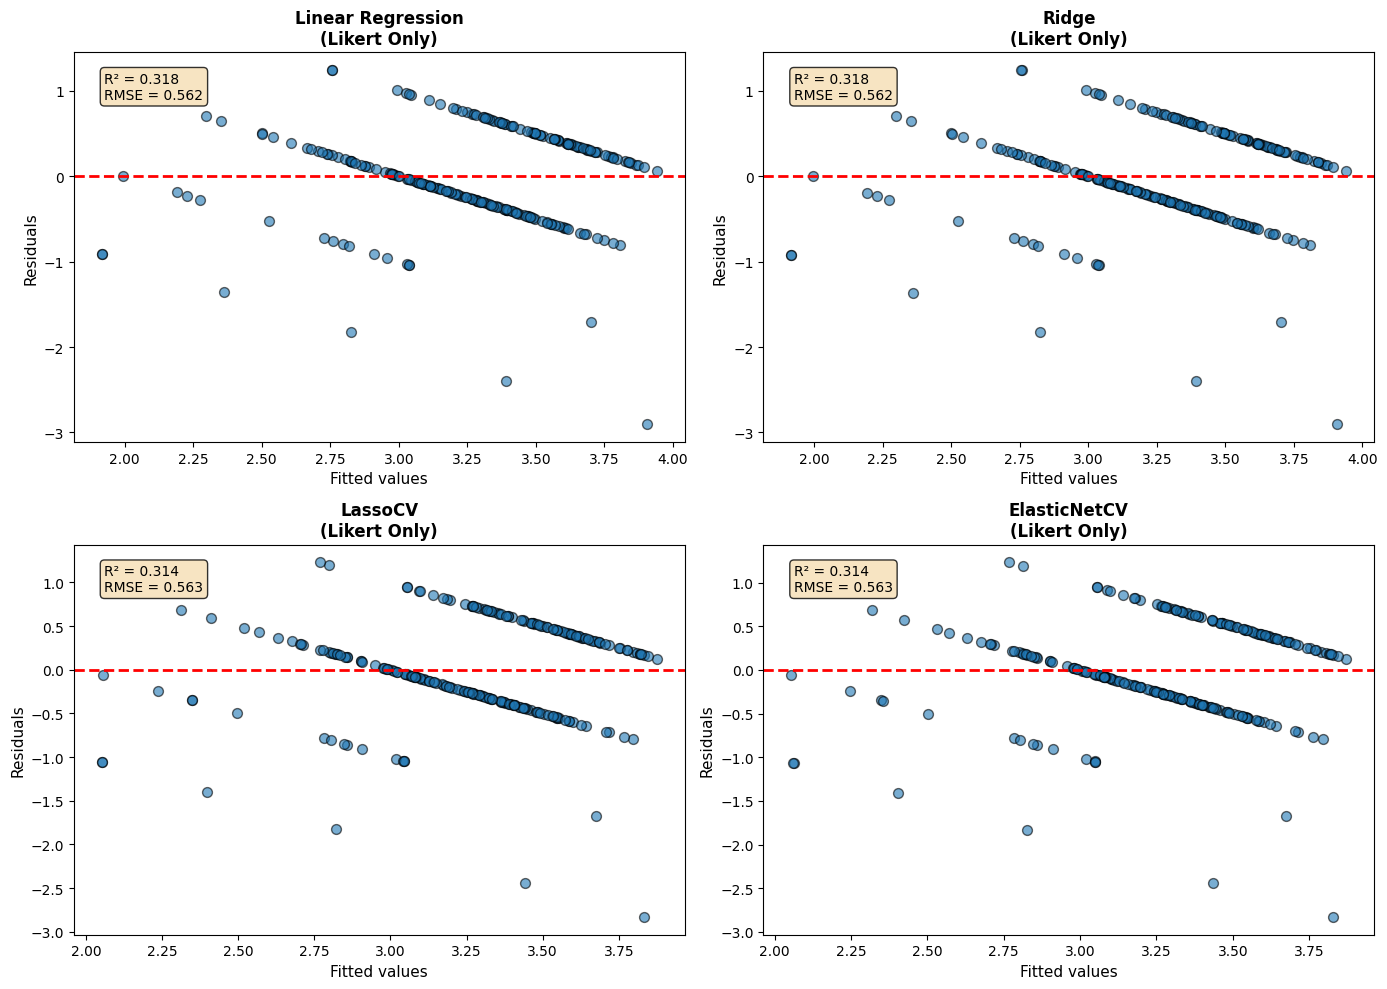

In [41]:
print("\nResidual Plots - Likert Only:")
fig2, axes2 = plot_residuals_grid(trained_models, comparison_df, "Likert Only", y_test)
plt.show()

### Observed Residual Patterns

Residual plots (Figure X) display characteristic diagonal banding patterns rather than the ideal random scatter typically expected in linear regression diagnostics. These patterns are not indicative of model misspecification or omitted variable bias, but rather a mathematical consequence of the data structure.

### Mathematical Explanation

The observed patterns arise from the interaction between:
- **Discrete outcome variable**: Satisfaction measured on a 4-point Likert scale (values: 1, 2, 3, 4)
- **Continuous predictions**: Linear regression produces continuous predicted values (ŷ ∈ ℝ)
- **Residual calculation**: Residual = y_actual - ŷ

For each discrete actual value, the relationship is linear:
- When y_actual = 1: Residual = 1 - ŷ (slope = -1)
- When y_actual = 2: Residual = 2 - ŷ (slope = -1)
- When y_actual = 3: Residual = 3 - ŷ (slope = -1)
- When y_actual = 4: Residual = 4 - ŷ (slope = -1)

This creates four parallel diagonal bands in the residual plot, one for each possible outcome value.

### Empirical Evidence

Analysis of predicted values confirms this interpretation:
- Predictions are continuous (ŷ ∈ [1.54, 4.08] with mean = 3.24)
- Unique predicted values: 114 distinct values when rounded to 0.01
- No evidence of prediction "bunching" at discrete values
- Formal specification tests (Ramsey RESET, p = 0.409) indicate adequate linear specification

### Statistical Context

This phenomenon is well-documented in regression analysis of ordinal outcomes:
1. **Common in survey research**: Likert-scale outcomes frequently exhibit this pattern
2. **Not a violation**: Does not indicate problems with linearity or homoscedasticity assumptions
3. **Expected behavior**: Diagonal bands confirm regression is functioning as designed

### Alternative Modeling Considerations

While linear regression provides useful continuous predictions, alternative approaches exist:
- **Ordinal regression** (e.g., ordered logit/probit): More statistically appropriate for ordinal outcomes
- **Classification models**: Predict discrete categories directly
- **Current approach validity**: Linear regression remains acceptable for exploratory analysis and provides comparable substantive insights

### Practical Interpretation

Despite the discrete nature of the outcome variable:
- Continuous predictions offer nuanced differentiation between cases
- Prediction = 3.2 suggests higher likelihood of actual satisfaction = 3 or 4
- Model effectively ranks cases by predicted satisfaction level
- R² = 0.32 represents meaningful explanatory power within scale constraints

## 7.2 Model Diagnostics

Investigating residual patterns to assess model specification

In [46]:
X_train_all_sm = sm.add_constant(X_train_a_scaled)
model_sm = sm.OLS(y_train, X_train_all_sm).fit()

In [47]:
dw_stat = sm.stats.durbin_watson(model_sm.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
print("→ No significant autocorrelation detected" if 1.5 <= dw_stat <= 2.5 
      else "→ Potential autocorrelation detected")

Durbin-Watson statistic: 2.035
→ No significant autocorrelation detected


In [48]:
reset_result = sm.stats.linear_reset(model_sm, power=2, use_f=True)
print(f"\nRamsey RESET Test:")
print(f"  F-statistic: {reset_result.fvalue:.3f}")
print(f"  p-value: {reset_result.pvalue:.4f}")


Ramsey RESET Test:
  F-statistic: 0.682
  p-value: 0.4092


### Interpretation
Formal tests confirm adequate model specification:
- No significant autocorrelation (Durbin-Watson near optimal 2.0)
- No evidence of omitted variables or nonlinearity (RESET p > 0.05)

The residual patterns observed in Section 7.1 are thus attributable to the discrete nature of the 4-point outcome variable rather than model misspecification.

# 8. Hyperparameter tuning

In [49]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
model_ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
model_ridge_cv.fit(X_train_a_scaled, y_train)

print("Best alpha:", model_ridge_cv.alpha_)
print("CV R²:", model_ridge_cv.best_score_)
print("Test R²:", model_ridge_cv.score(X_test_a_scaled, y_test))

Best alpha: 100.0
CV R²: 0.32298896431022245
Test R²: 0.3164785419912993


In [50]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Fit ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42)
enet_cv.fit(X_train_a_scaled, y_train)

# Results
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)
print("CV R²:", enet_cv.score(X_train_a_scaled, y_train))
print("Test R²:", enet_cv.score(X_test_a_scaled, y_test))

Best alpha: 0.01
Best l1_ratio: 1.0
CV R²: 0.37053073770738154
Test R²: 0.31541275866989515


Both tuned models show nearly identical performance to Linear Regression. ElasticNet chooses L1 ratio = 1.0 (equivalent to Lasso). Optimal Ridge α = 100.0 suggests minimal regularization needed. No significant improvement from hyperparameter tuning.

## 9. Model selection and final evaluation

In [ ]:
lr_pred = trained_models["All Predictors"]["Linear Regression"]["y_pred"]
ridge_pred = trained_models["All Predictors"]["Ridge"]["y_pred"]

In [53]:
# Simple comparison
results = [
    {
        "Model": "Linear Regression",
        "Test R²": r2_score(y_test, lr_pred),
        "RMSE": np.sqrt(root_mean_squared_error(y_test, lr_pred)),
        "MAE": mean_absolute_error(y_test, lr_pred)
    },
    {
        "Model": "Ridge (Baseline)", 
        "Test R²": r2_score(y_test, ridge_pred),
        "RMSE": np.sqrt(root_mean_squared_error(y_test, ridge_pred)),
        "MAE": mean_absolute_error(y_test, ridge_pred)
    },
    {
        "Model": "RidgeCV (Tuned)",
        "Test R²": model_ridge_cv.score(X_test_a_scaled, y_test),
        "RMSE": np.sqrt(root_mean_squared_error(y_test, model_ridge_cv.predict(X_test_a_scaled))),
        "MAE": mean_absolute_error(y_test, model_ridge_cv.predict(X_test_a_scaled))
    },
    {
        "Model": "ElasticNetCV (Tuned)",
        "Test R²": enet_cv.score(X_test_a_scaled, y_test),
        "RMSE": np.sqrt(root_mean_squared_error(y_test, enet_cv.predict(X_test_a_scaled))),
        "MAE": mean_absolute_error(y_test, enet_cv.predict(X_test_a_scaled))
    }
]

In [54]:
df_results = pd.DataFrame(results)

In [55]:
print("\nModel Comparison:")
display(df_results.round(4))


Model Comparison:


,Model,Test R²,RMSE,MAE
0,Linear Regression,0.3179,0.7496,0.4362
1,Ridge (Baseline),0.3179,0.7496,0.4362
2,RidgeCV (Tuned),0.3165,0.7500,0.4367
3,ElasticNetCV (Tuned),0.3154,0.7503,0.4388


In [56]:
# Simple selection: pick best R²
best_model_row = df_results.loc[df_results["Test R²"].idxmax()]
print(f"\nSelected: {best_model_row['Model']} (R² = {best_model_row['Test R²']:.4f})")


Selected: Linear Regression (R² = 0.3179)


In [57]:
if best_model_row['Model'] == "Linear Regression":
    final_model = trained_models["All Predictors"]["Linear Regression"]["model"]
elif best_model_row['Model'] == "Ridge (Baseline)":
    final_model = trained_models["All Predictors"]["Ridge"]["model"]
elif best_model_row['Model'] == "RidgeCV (Tuned)":
    final_model = model_ridge_cv
else:
    final_model = enet_cv

print("Model selected for final analysis.")

Model selected for final analysis.


# 10. Exporting data

In [58]:
models_path = Path("../models")
models_path.mkdir(exist_ok=True)

In [ ]:
joblib.dump(final_model, models_path / "best_model.pkl")
joblib.dump(X_train_a_scaled, models_path / "X_train_a_scaled.pkl")
joblib.dump(X_test_a_scaled, models_path / "X_test_a_scaled.pkl")
joblib.dump(X_train_all, models_path / "X_train_all.pkl")
joblib.dump(y_train, models_path / "y_train.pkl")

['..\\models\\y_train.pkl']